In [1]:
%gui tk
%matplotlib inline

import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
# from skimage.io import imread
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#to increase accuracy, all images should have the same initial pixel/µm resolution

IMAGE_HEIGHT = 416
IMAGE_WIDTH = 416
IMAGE_CHANNELS = 3
BOX_WIDTH = 15 #px
BOX_HEIGHT = 15 #px

In [3]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [4]:
# Choose directory with image and coordinate folders
data_dir = os.path.normpath(filedialog.askdirectory())

In [5]:
# Create a dataframe for images and coordinates
all_images = glob(os.path.join(data_dir, '*', '*.tif'))
all_info = glob(os.path.join(data_dir, '*', '*.txt'))
img_df = pd.DataFrame({'img_path': all_images, 'info_path': all_info})
img_id = lambda in_path: in_path.split('\\')[-2][-6:]
img_df['ImageID'] = img_df['img_path'].map(img_id)

In [6]:
# define regular expressions to get coordinates
regexp_x = re.compile("x = (-?[0-9.]*),")
regexp_y = re.compile("y = (-?[0-9.]*)\n")
# TODO: figure out how to deal with negative coordinates (errors?) 

In [14]:
# function to read coordinates from text file
def read_and_parse_coordinates(info_file):
#     print(info_file)
    file = open(info_file, "r")
    lines = file.readlines()
#     x = []
#     y = []
    xy = []
    for line in lines:
        xi = regexp_x.search(line)
        yi = regexp_y.search(line)
        if xi and yi:
#             x.append(xi.group(1))
#             y.append(regexp_y.search(line).group(1))
            x = xi.group(1)
            y = yi.group(1)
            xy.append(np.array([x,y], dtype = np.float32))
    file.close()
#     return np.array([np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)])
    return np.array(xy)

In [8]:
# function to read images from files
def load_image(img_file):
    image = np.array(PIL.Image.open(img_file), dtype = np.uint8)
#     image = imread(img_file)
    image = np.stack([image,image,image], 2)
    return image

In [15]:
# load coordinates and images from files
img_df['x_y_coordinates'] = img_df['info_path'].map(read_and_parse_coordinates)
img_df['images'] = img_df['img_path'].map(load_image)

In [16]:
img_df.sample(1)

,img_path,info_path,ImageID,x_y_coordinates,images
2364,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,002365,"[[72.0, 73.0], [72.0, 128.0]]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


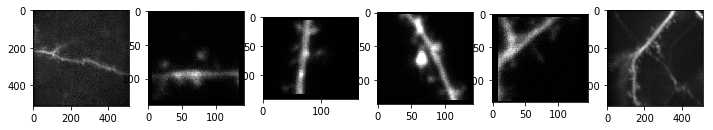

In [18]:
#Show a few sample images
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].sample(n_img), range(6)):
    m_axs[ax_ind].imshow(img)

plt.show(fig)

In [19]:
# function to identify which images need to be expanded 
def flag_big_images(image):
    orig_height, orig_width = image.shape[0], image.shape[1]
    big_image_flag = False
    if orig_height > IMAGE_HEIGHT or orig_width > IMAGE_WIDTH:
        big_image_flag = True
    return big_image_flag

In [20]:
# flag big images
img_df['big_image_flag'] = img_df['images'].map(flag_big_images)

In [21]:
# function to split images into proper heights/widths
# any files split too small will be padded later on
# this function should only take rows of images which have been flagged as large
def split_large_images_and_coordinates(row):
    image = row['images']
    orig_height, orig_width = image.shape[0], image.shape[1]
    #first, split images by height
    split_indices_height = np.array(range(IMAGE_HEIGHT,orig_height,IMAGE_HEIGHT))
    split_indices_width = np.array(range(IMAGE_WIDTH,orig_width,IMAGE_WIDTH))        
    images_split_height = np.split(image, split_indices_height, axis = 0)
    #split coordinates by y, accordingly
    x_y_coordinates = row['x_y_coordinates']
    #split coordinates into individual lists for indexing
    x_all = np.array([x for x,_ in x_y_coordinates])
    y_all = np.array([y for _,y in x_y_coordinates])
    if len(split_indices_width) > 0:
        x_indices = np.digitize(x_all, split_indices_width)
    else: x_indices = np.zeros(x_all.shape, dtype = np.uint8)
            
    if len(split_indices_height) > 0:
        y_indices = np.digitize(y_all, split_indices_height)
    else: y_indices = np.zeros(y_all.shape, dtype = np.uint8)

    # coordinates are split into matrix in shape of split image
    coordinates_split = np.empty((len(split_indices_height)+1,len(split_indices_width)+1), dtype = np.object)
    for xy,x_ind,y_ind in zip(x_y_coordinates,x_indices,y_indices):
        if coordinates_split[y_ind,x_ind] is None:
            coordinates_split[y_ind,x_ind] = []
        # correct coordinates for amount of pixels which are removed before them
        # this only works if coordinates are calculated from top left so make sure that's the case
#         x_corrected = x - x_ind * IMAGE_WIDTH
#         y_corrected = y - y_ind * IMAGE_HEIGHT
        x_y_corrected = xy - np.array([x_ind * IMAGE_WIDTH, y_ind * IMAGE_HEIGHT])
        coordinates_split[y_ind,x_ind].append(x_y_corrected)
    # flatten coordinate matrix so its shape aligns with images_split
    coordinates_split = coordinates_split.flatten().tolist()
    #translate all lists to numpy arrays
    coordinates_split = [np.array(x) for x in coordinates_split]
    images_split = []
    #create now, split images by width and create list of all images
    for image_split_height in images_split_height:
        images_split += np.split(image_split_height, split_indices_width, axis = 1)
    return images_split, coordinates_split

In [ ]:
# testing split_images_and_coordinates function
# img_df[img_df['big_image_flag']].sample(1)
# row = img_df.loc[718]
# _,_ = split_large_images_and_coordinates(row)

In [22]:
# split images and coordinates and put them in new dataframe
images_split_all = []
coordinates_split_all = []
#create row with dataframe structure to add on to
df_addon = img_df.loc[[0]].copy()
for index,row in img_df[img_df['big_image_flag']].iterrows():
    # create dummy row from current one
    clean_row = img_df.loc[[index]].copy()
    clean_row['images'] = None
    clean_row['x_y_coordinates'] = None
    images_split, coordinates_split = split_large_images_and_coordinates(row)
    images_split_all += images_split
    coordinates_split_all += coordinates_split
#     print(len(coordinates_split))
    df_addon = df_addon.append([clean_row]*len(images_split), ignore_index = True)
df_addon = df_addon.drop(index = 0)
df_addon['images']=np.array(images_split_all)
df_addon['x_y_coordinates'] = np.array(coordinates_split_all)
# df_addon.sample(1)

In [23]:
# remove big images from original dataframe and append new rows
img_df = img_df.drop(index = img_df[img_df['big_image_flag']].index)
img_df = img_df.append(df_addon,ignore_index = True)
# rename big_image_flag column to split_image
img_df = img_df.rename(columns = {'big_image_flag':'split_image'})
# img_df.loc[[len(img_df)-10]]

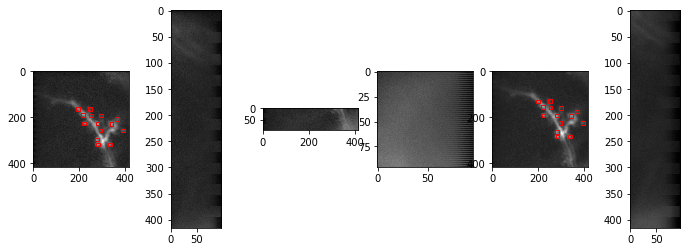

In [24]:
#Show a few sample split images with boxes
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(images_split_all[:n_img], range(6)):
    m_axs[ax_ind].imshow(img)
    if sum(coordinates_split_all[ax_ind].shape) > 0:
        for xy in coordinates_split_all[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
            x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle((x_y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)

In [25]:
# get image shapes
img_df['shape'] = img_df['images'].map(lambda x: x.shape)
# img_df.sample(2)

In [26]:
# Calculate max dimensions
# max_y,max_x,max_z = 0,0,0
# for y,x,z in img_df['shape']:
#     max_x = np.max([max_x, x])
#     max_y = np.max([max_y, y])
#     max_z = np.max([max_z, z])
# max_y, max_x, max_z
max_y, max_x, max_z = IMAGE_HEIGHT, IMAGE_WIDTH, 3

In [27]:
# function to pad images and shift coordinates accordingly

def pad_image_and_shift_coordinates(row):
    image = row['images']
    y,x,z = image.shape
    pad_y, pad_x, pad_z = max_y - y, max_x - x, max_z - z
    y1,y2 = np.floor(pad_y/2).astype(int), np.floor(pad_y/2).astype(int) + pad_y%2
    x1,x2 = np.floor(pad_x/2).astype(int), np.floor(pad_x/2).astype(int) + pad_x%2
    z1,z2 = np.floor(pad_z/2).astype(int), np.floor(pad_z/2).astype(int) + pad_z%2
    row['images_padded'] = np.pad(image, ((y1,y2),(x1,x2),(z1,z2)), mode = 'constant')
    if row['x_y_coordinates'] is None:
        row['x_y_coordinates_shifted'] = None
        return row
    row['x_y_coordinates_shifted'] = row['x_y_coordinates'].copy()
#     row['x_y_coordinates_shifted'][0] = row['x_y_coordinates'][0] + x1
#     row['x_y_coordinates_shifted'][1] = row['x_y_coordinates'][1] + y1
    if sum(row['x_y_coordinates_shifted'].shape) >0: #to make sure it's not empty
        row['x_y_coordinates_shifted'] = row['x_y_coordinates']+ np.array([x1,y1])
    return row

In [28]:
#function to make boxes from given coordinates
def coords_to_boxes(x_y_coordinates):
    #boxes is an array of shape (num_boxes,5) containing 1D list of class, x_min, y_max, x_max, y_max.
    # class is always labeled as "1" for spine since that's the only thing we're looking for. DOOOEEEEEE
    boxes = []
    if sum(x_y_coordinates.shape) > 0:
        for x,y in x_y_coordinates:
            box = np.array([1, x-BOX_WIDTH/2,y-BOX_HEIGHT/2, x+BOX_WIDTH/2,y+BOX_HEIGHT/2])
            boxes.append(box)
    return np.array(boxes)


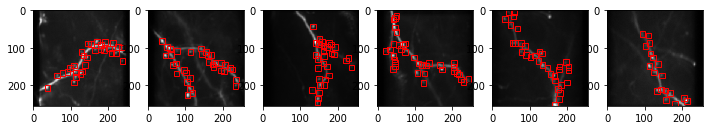

In [29]:
#Show a few sample split images with boxes
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].loc[:n_img], range(6)):
    m_axs[ax_ind].imshow(img)
    if sum(img_df['x_y_coordinates'].loc[ax_ind].shape) > 0:
        for xy in img_df['x_y_coordinates'].loc[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
            x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle((x_y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)


In [30]:
#Apply padding to all images and shift coordinates respectively
img_df = img_df.apply(pad_image_and_shift_coordinates, axis = 1)
img_df.loc[0]


img_path                   C:\Users\smirnovm\Documents\Data\Labeled_Spine...
info_path                  C:\Users\smirnovm\Documents\Data\Labeled_Spine...
ImageID                                                               000001
x_y_coordinates            [[38.0, 208.0], [64.0, 174.0], [78.0, 167.0], ...
images                     [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [2, 2, 2], ...
split_image                                                            False
shape                                                          (256, 256, 3)
images_padded              [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
x_y_coordinates_shifted    [[118.0, 288.0], [144.0, 254.0], [158.0, 247.0...
Name: 0, dtype: object

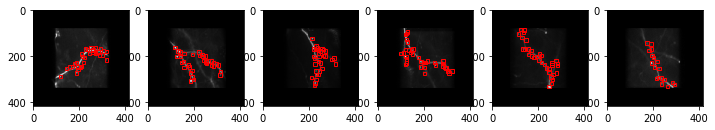

In [31]:
#Show a few sample split images with boxes
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images_padded'].loc[:n_img], range(6)):
    m_axs[ax_ind].imshow(img)
    if sum(img_df['x_y_coordinates_shifted'].loc[ax_ind].shape) > 0:
        for xy in img_df['x_y_coordinates_shifted'].loc[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
            x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle((x_y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)

In [32]:
#map all coordinates to boxes
img_df['boxes'] = img_df['x_y_coordinates_shifted'].map(coords_to_boxes)
#preview dataframe
img_df.sample(2)

,img_path,info_path,ImageID,x_y_coordinates,images,split_image,shape,images_padded,x_y_coordinates_shifted,boxes
3376,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000452,"[[136.0, 172.0], [182.0, 194.0], [104.0, 176.0...","[[[1, 1, 1], [1, 1, 1], [4, 4, 4], [2, 2, 2], ...",True,"(416, 416, 3)","[[[1, 1, 1], [1, 1, 1], [4, 4, 4], [2, 2, 2], ...","[[136.0, 172.0], [182.0, 194.0], [104.0, 176.0...","[[1.0, 128.5, 164.5, 143.5, 179.5], [1.0, 174...."
3336,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000440,"[[168.0, 64.0], [195.0, 57.0], [188.0, 95.0], ...","[[[12, 12, 12], [11, 11, 11], [5, 5, 5], [9, 9...",True,"(416, 416, 3)","[[[12, 12, 12], [11, 11, 11], [5, 5, 5], [9, 9...","[[168.0, 64.0], [195.0, 57.0], [188.0, 95.0], ...","[[1.0, 160.5, 56.5, 175.5, 71.5], [1.0, 187.5,..."


In [33]:
# convert to array
# images = img_df['images_padded'].as_matrix()
# boxes = img_df['boxes'].as_matrix()
# save array
file_name = 'spine_images_and_boxes.pkl'
# np.savez('spine_images_and_boxes',images = images,boxes = boxes)
# file can be loaded and accessed by 
# npzfile = np.load('spine_images_and_boxes.npz')
# npzfile['images']...
# save as h5py
# with h5py.File('spine_images_and_boxes.h5', 'w') as hf:
#     hf.create_dataset('images', data = images)
#     hf.create_dataset("boxes", data = boxes)
img_df.to_pickle(file_name)
# store = pd.HDFStore(file_name)

# store['img_df'] = img_df  # save it
# store['df']  # load it

In [ ]:
# load sample underwater_data.npz to check what data should look like
# underwater_data = np.load('..//data//underwater_data.npz')

In [ ]:
# underwater_data['boxes'][50]

In [ ]:
#save two samples for testing training algorithm
np.savez('spine_images_and_boxes_2_sample', images = images[220:222], boxes = boxes[220:222])

In [ ]:
images[0].shape